Phase values per macropixel for each spin (k=0):
Spin 0: [np.float64(3.141384794420548), np.float64(0.00020785916924515035), np.float64(3.141384794420548), np.float64(0.00020785916924515035), np.float64(3.141384794420548), np.float64(0.00020785916924515035), np.float64(3.141384794420548), np.float64(0.00020785916924515035), np.float64(3.141384794420548), np.float64(0.00020785916924515035)] ...
Spin 1: [np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261)] ...


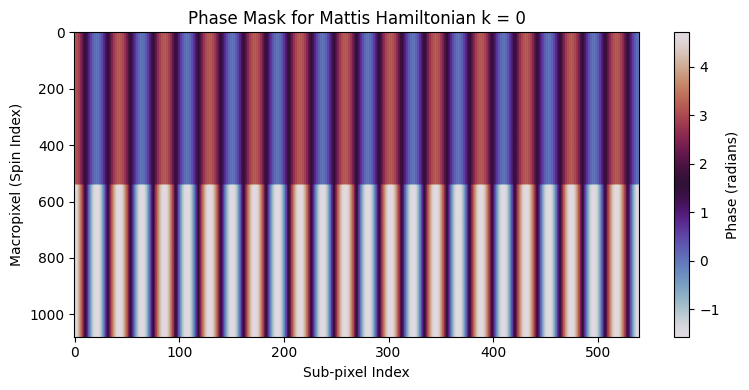

Phase values per macropixel for each spin (k=1):
Spin 0: [np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261), np.float64(4.7121811212158935), np.float64(-1.5705884676261)] ...
Spin 1: [np.float64(3.1418005127590387), np.float64(-0.0002078591692453724), np.float64(3.1418005127590387), np.float64(-0.0002078591692453724), np.float64(3.1418005127590387), np.float64(-0.0002078591692453724), np.float64(3.1418005127590387), np.float64(-0.0002078591692453724), np.float64(3.1418005127590387), np.float64(-0.0002078591692453724)] ...


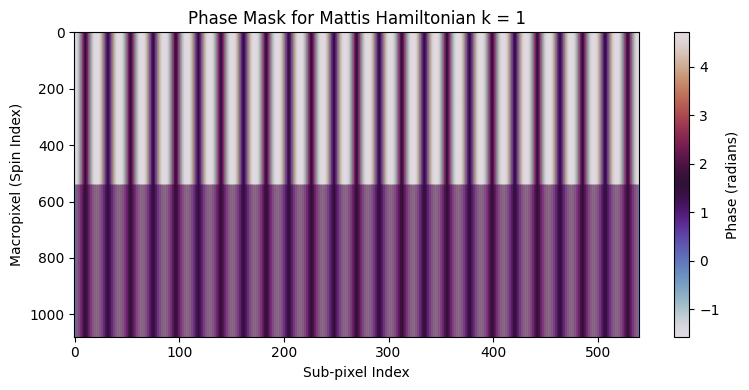

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class PhaseEncodingSPIM:
    def __init__(self, slm_width=1920, slm_height=1080, spin_vector):
        self.SLM_WIDTH = slm_width
        self.SLM_HEIGHT = slm_height
        self.n_spins = np.shape(spin_vector)[0]  # Number of spins from the provided spin vector
        self.MACRO_PIX_X = None
        self.MACRO_PIX_Y = None
        self.beam_sigma_x = None
        self.beam_sigma_y = None
        self.center_x = self.SLM_WIDTH / 2
        self.center_y = self.SLM_HEIGHT / 2
        self.I = None
        self.Ai = None
        self.J = None
        self.eigvals = None
        self.eigvecs = None
        self.spins = spin_vector

    def get_number_of_spins(self):
        self.n_spins = int(input("Enter number of spins: "))
        if self.n_spins < 1:
            raise ValueError("Number of spins must be at least 1.")

    def choose_macropixel_size(self):
        tile_x = self.SLM_WIDTH // self.n_spins
        tile_y = self.SLM_HEIGHT // self.n_spins
        min_tile = min(tile_x, tile_y)
        if min_tile < 2:
            raise ValueError(
                f"SLM too small for {self.n_spins} spins: max square block size = {min_tile}x{min_tile}."
            )
        self.MACRO_PIX_X = self.MACRO_PIX_Y = min_tile
        print(f"Using square macropixel size {self.MACRO_PIX_X}x{self.MACRO_PIX_Y} for {self.n_spins} spins on a {self.SLM_WIDTH}x{self.SLM_HEIGHT} SLM.")

    def get_gaussian_parameters(self):
        print("\nEnter Gaussian beam parameters for compensation:")
        self.beam_sigma_x = float(input("Beam waist sigma_x (in pixels): "))
        self.beam_sigma_y = float(input("Beam waist sigma_y (in pixels): "))

    def build_intensity_map(self):
        xs = np.arange(self.SLM_WIDTH)
        ys = np.arange(self.SLM_HEIGHT)
        X, Y = np.meshgrid(xs, ys)
        self.I = np.exp(-2 * (((X - self.center_x)**2 / self.beam_sigma_x**2) + ((Y - self.center_y)**2 / self.beam_sigma_y**2)))

    def compute_compensation_factors(self):
        Ii = np.zeros(self.n_spins)
        for i in range(self.n_spins):
            x0 = i * self.MACRO_PIX_X
            y0 = i * self.MACRO_PIX_Y
            block = self.I[y0:y0+self.MACRO_PIX_Y, x0:x0+self.MACRO_PIX_X]
            Ii[i] = block.mean()
        wi = np.max(Ii) / Ii
        ci = np.sqrt(wi)
        self.Ai = ci / np.max(ci)
        print("\nGaussian compensation factors A_i:")
        for i, a in enumerate(self.Ai):
            print(f"Spin {i}: A_i = {a:.3f}")

    def get_interaction_matrix(self):
        print(f"\nEnter the {self.n_spins}x{self.n_spins} interaction matrix J row by row (must be symmetric):")
        J = []
        for i in range(self.n_spins):
            row = list(map(float, input(f"Row {i+1}: ").split()))
            if len(row) != self.n_spins:
                raise ValueError(f"Row {i+1} length ({len(row)}) does not match number of spins ({self.n_spins}).")
            J.append(row)
        self.J = np.array(J)
        if not np.allclose(self.J, self.J.T):
            max_diff = np.max(np.abs(self.J - self.J.T))
            raise ValueError(
                f"Interaction matrix is not symmetric (max asymmetry={max_diff:.3e}). Please provide a symmetric matrix."
            )
        print("\nInput Interaction Matrix J (symmetric):")
        print(self.J)

    def eigen_decomposition(self):
        self.eigvals, self.eigvecs = np.linalg.eigh(self.J)
        # print("\nEigenvalues of J:")
        # print(self.eigvals)
        # print("\nEigenvectors of J:")
        # print(self.eigvecs)

    # def random_spin_configuration(self):
    #     self.spins = np.random.choice([-1, 1], size=self.n_spins)
    #     print("\nRandom spin configuration:")
    #     print(self.spins)

    def encode_and_display(self):
        for k in range(self.n_spins):
            # print(f"\n--- Mattis Hamiltonian k = {k} ---")
            xi_k = self.eigvecs[:, k]
            xi_comp = self.Ai * xi_k
            xi_comp = np.clip(xi_comp, -1.0, 1.0)
            alpha_ik = np.arccos(xi_comp)

            phase_mask = np.zeros((self.n_spins * self.MACRO_PIX_Y, self.MACRO_PIX_X))
            for i in range(self.n_spins):
                for l in range(self.MACRO_PIX_X):
                    phi_raw = self.spins[i] * (np.pi/2) + ((-1)**l) * alpha_ik[i]
                    phi_slm = phi_raw + 2 * np.pi
                    phase_mask[i*self.MACRO_PIX_Y:(i+1)*self.MACRO_PIX_Y, l] = phi_slm

         #   print("Phase values per macropixel for each spin (with compensation and +2π shift):")
            for i in range(self.n_spins):
                phases = []
                for l in range(self.MACRO_PIX_X):
                    phi_raw = self.spins[i] * (np.pi/2) + ((-1)**l) * alpha_ik[i]
                    phases.append(phi_raw + 2 * np.pi)
        #        print(f"Spin {i}: {phases}")

            plt.figure(figsize=(8, 4))
            plt.imshow(phase_mask, cmap='twilight', aspect='auto')
            plt.colorbar(label='Phase (radians)')
            plt.title(f'Compensated Phase Mask for Mattis Hamiltonian k = {k}')
            plt.xlabel('Sub-pixel Index')
            plt.ylabel('Macropixel (Spin Index)')
            plt.tight_layout()
            plt.show()
            return phase_mask

    def run(self):
        self.get_number_of_spins()
        self.choose_macropixel_size()
        self.get_gaussian_parameters()
        self.build_intensity_map()
        self.compute_compensation_factors()
        self.get_interaction_matrix()
        self.eigen_decomposition()
        self.random_spin_configuration()
        self.encode_and_display()
        print(self.spins)

# To run:
if __name__ == "__main__":
    spim = PhaseEncodingSPIM()
    spim.run()